# Przewidywanie spożycia alkoholu przez studentów z wykorzystaniem prostej sieci neuronowej
Autorzy:  
- Mateusz Chruściel  
- Paweł Kotiuk  

## Analiza Zbioru danych
Dane omawiane w niniejszym dokumencie pobrane są ze strony https://www.kaggle.com/uciml/student-alcohol-consumption  
Zawierają one wyniki ankiety przeprowadzonej pośród studentów dwóch kursów: matematyki oraz portugalskiego. Podczas ankiety zebrano wiele danych o respondentach takie jak, wiek, oceny, rozmiar rodziny, czy też średnie spożycie alkoholu, które będzie przedmiotem niniejszej analizy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from subprocess import check_output
pd.set_option('display.max_columns', 10)
math_class_data = pd.read_csv(os.path.abspath('') + "/data/student-mat.csv", delimiter=";")
port_class_data = pd.read_csv(os.path.abspath('') + "/data/student-por.csv", delimiter=";")
data = math_class_data.append(port_class_data)
data = data[['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
            'Mjob','Fjob','reason', 'guardian', 'traveltime', 'studytime',
            'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
            'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
            'Walc', 'health', 'absences', 'G1', 'G2', 'G3']]
numeric_values = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
                  'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
binary_values = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup',
                 'famsup', 'paid', 'higher', 'activities', 'nursery', 'internet', 'romantic']
nominal_values = ['reason', 'guardian','Mjob','Fjob']
data


,school,sex,age,address,famsize,...,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,...,3,6,5,6,6
1,GP,F,17,U,GT3,...,3,4,5,5,6
2,GP,F,15,U,LE3,...,3,10,7,8,10
3,GP,F,15,U,GT3,...,5,2,15,14,15
4,GP,F,16,U,GT3,...,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,...,5,4,10,11,10
645,MS,F,18,U,LE3,...,1,4,15,15,16
646,MS,F,18,U,GT3,...,5,6,11,12,9
647,MS,M,17,U,LE3,...,2,6,10,10,10


Pozwoliliśmy sobie na połączenie danych z dwóch kursów, ponieważ różnice wynikające z możliwych różnic w poziomach trudności (a co za tym idzie ocen) sa minimalne.  
  
Dane ną pełne, nie ma tu pustych komórek, co ułatwi trening sieci.  
Mamy tu ponad 1000 rekodrów, co wg informacji z wykładu powinno pozwolić na wytrenowanie sieci zawierającej (w przubliżeniu) do 100 neuronów.

W zbiorze danych mamy do czynienia z dwoma typami parametrów:
- liczbowe - wiek, wyniki ocen
- binarne - wsparcie rodziny, branie dodatkowych aktywności
- nominalne - płeć, miejsce zamieszkania, powód wybrania kursu

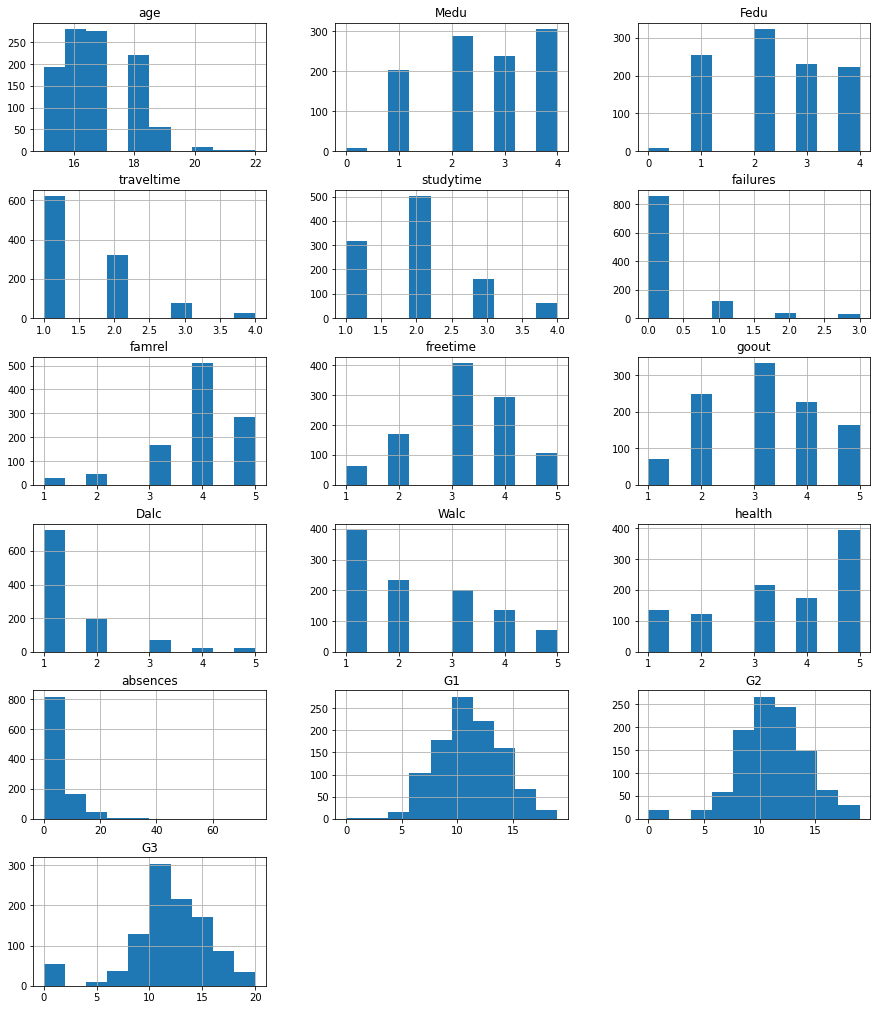

In [2]:
x = data[numeric_values].hist(figsize=(15,30),ylabelsize=10,layout=(10,3))

W wypadku histogramów dla wartości numerycznych można zauważyć, że w wielu wypadkach ich rozkład odpowiada rozkładowi normalnemu.

In [3]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]]
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (3 * nGraphPerRow, 3 * nGraphRow), dpi = 80)
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]}')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

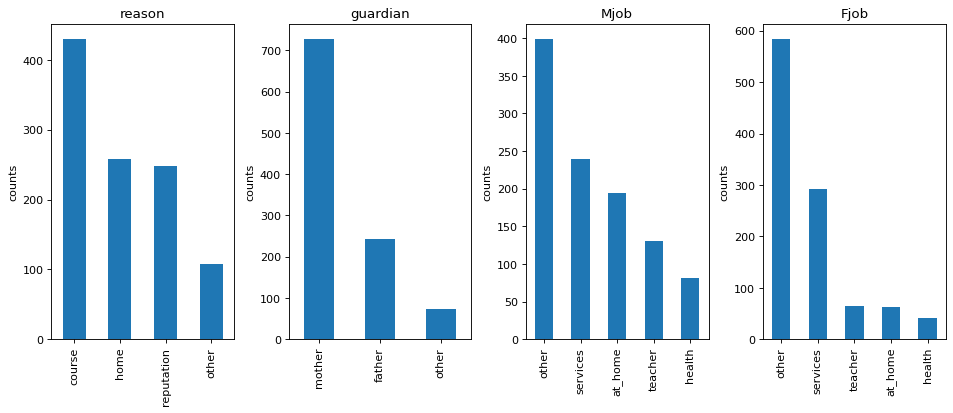

In [4]:
plotPerColumnDistribution(data[nominal_values],4,4)

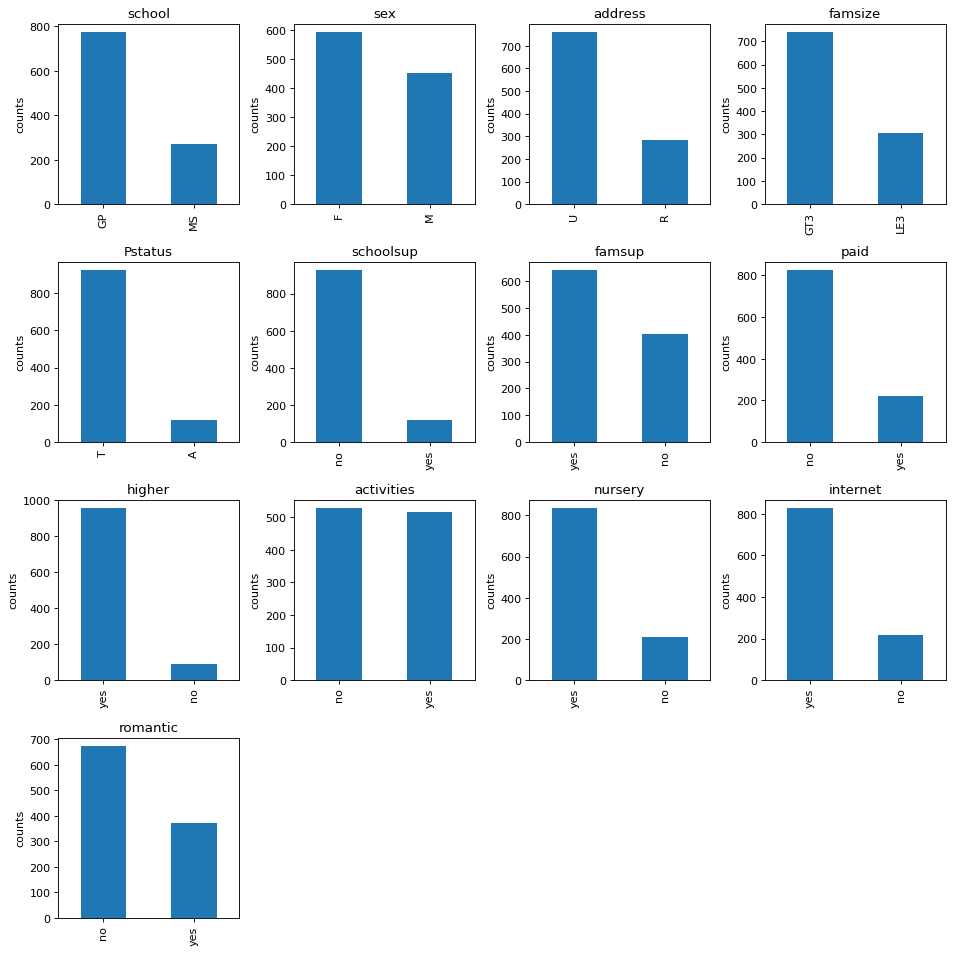

In [5]:
plotPerColumnDistribution(data[binary_values], len(binary_values), 4)

<AxesSubplot:>

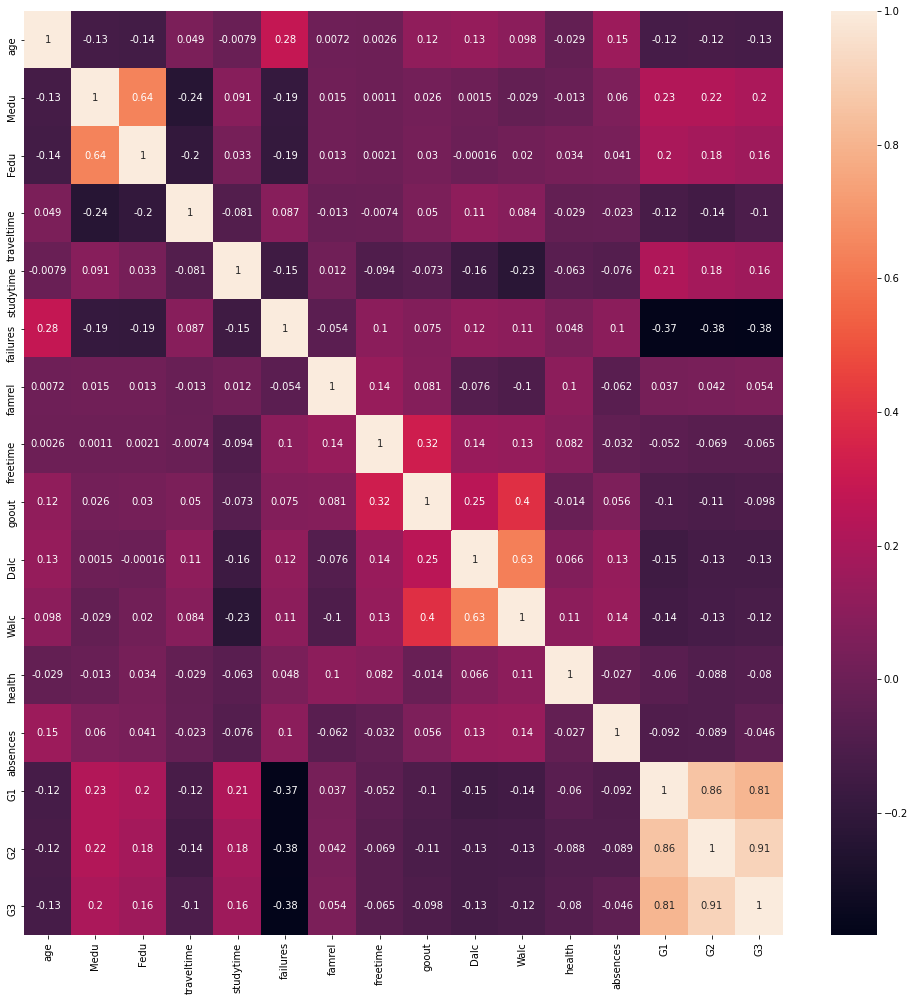

In [6]:
import seaborn as sns
plt.figure(figsize=(17,17))
sns.heatmap(data.corr(),annot = True)

Z powyższej mapy korelacji można wywnioskować pewne prostsze zależności dotyczące spożycia alkoholu wśród uczestników kursu.  
Można zauważyć, że spożycie alkoholu jest proporcjonalne do częstotliwości wyjść, zaś odwrotnie proporcjonalne do ilości czasu spędzonego na nauce.

## Uczenie stworzonej sieci

Przewidywanie spożycia alkoholu wśród studentów biorących udział w kursie potraktujemy jako problem klasyfikacji, w ramach którego postaramy sie przyporządkować studentów do odpowiednich grup.

W pierwszym kroku importujemy oraz konwertujemy dane do formatu zalecanego dla sieci neuronowych, te z danych wejściowych, które mają wartości liczbowe zostały przeskalowane, tak, aby ich średnia wynosiła 0, a odchylenie standardowe 1, dane binarne zostały przekonwertowane na zera i jedynki, a dane opisujące klasy zostały podzielone za pomocą metody One Hot Spot.
Dane wyjściowe także zostały przekonwertowane z wykorzystaniem tej metody.

Dodatkowo podzieliśmy dane na dwa zbiory:  
- treningowy, którego dane będą wykorzystane do uczenia sieci
- testowy, który będzie wykorzystany do walidanci efektów uczenia sieci

In [1]:
from application import *
from sklearn.model_selection import train_test_split
d = DataClass()

X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(d.data_to_network, d.output_walc, test_size=0.2)
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(d.data_to_network, d.output_dalc, test_size=0.2)

W następnym kroku tworzymy dwie sieci neuronowe, określamy ich wymiary wejściowe, wyjściowe oraz ilość i wymiary poszczególnych warstw wewnętrznych.

In [8]:
nn_walc = NeuralNetwork(d.get_num_of_columns(),[20],5, "relu")
nn_dalc = NeuralNetwork(d.get_num_of_columns(),[20],5, "relu")

Teraz możemy przejść do właściwego treningu sieci neuronowej.
Na tym etapie dobieramy takie kluczowe parametry jak:
- liczba epok
- *batch_size* - opisujący w jakich grupach będą podzielone nasze próbki
- *learning_rate* - współczynnik regulujący wielkość kroku naszej funkcji

In [9]:
epochs_number = 1000
print("Walc")
nn_walc.train(train_data=X_train_w,targets=y_train_w,epochs=epochs_number,batch_size=10,learning_rate=0.001,number_of_prints=5)
print("Dalc")
nn_dalc.train(train_data=X_train_d,targets=y_train_d,epochs=epochs_number,batch_size=10,learning_rate=0.001,number_of_prints=5)

Walc
epochs: 200 ==== error: 0.2471238707507825
epochs: 400 ==== error: 0.23459486434034146
epochs: 600 ==== error: 0.23026363189141494
epochs: 800 ==== error: 0.2282308684194832
epochs: 1000 ==== error: 0.2270510325178856
Dalc
epochs: 200 ==== error: 0.15800232530577837
epochs: 400 ==== error: 0.1541278488223217
epochs: 600 ==== error: 0.15151579476274307
epochs: 800 ==== error: 0.14952083544647135
epochs: 1000 ==== error: 0.1478941751275335


In [10]:
print("Dokładność przeiwdywań dla weekendowego spożycia:",round(nn_walc.test(np.asarray(X_test_w),np.asarray(y_test_w))*100,4),"%")
print("Dokładność przeiwdywań dla dziennego spożycia:",round(nn_dalc.test(np.asarray(X_test_d),np.asarray(y_test_d))*100,4),"%")

Dokładność przeiwdywań dla weekendowego spożycia: 43.5407 %
Dokładność przeiwdywań dla dziennego spożycia: 68.8995 %


Dla dobranych parametrów nauczania udało się uzyskać przewidywanie sieci z dokładnością w okolicach 45% dla weekendowego spożycia oraz 75% dla dziennego, co nie jest zbyt dobrym wynikiem, zwłaszcza biorąc pod uwagę to, że zbliżone wyniki można uzyskać po prostu zawsze zwracając wartość najczęściej pojawiającą się w zbiorze ( w tym wypadku 1 dla obu zbiorów).   
Taki wynik może świadczyć o braku prostych korelacji pomiędzy poszczególnymi parametrami, bądź też o niewłaściwym doborze parametrów/konfiguracji sieci.

Z tego powodu zdecydowaliśmy się na zbadanie tych danych także za pomocą innej, gotowej implementacji sieci neuronowej.

In [11]:
from sklearn.neural_network import MLPClassifier
clf_w = MLPClassifier(random_state=1, max_iter=epochs_number,hidden_layer_sizes=(20,)).fit(X_train_w, y_train_w)
print("Dokładność przwidywań dla weekendowego spożycia:", round(100*clf_w.score(X_test_w, y_test_w),3),"%")
clf_d = MLPClassifier(random_state=1, max_iter=epochs_number,hidden_layer_sizes=(20,)).fit(X_train_d, y_train_d)
print("Dokładność przwidywań dla dziennego spożycia:", round(100*clf_d.score(X_test_d, y_test_d),3),"%")

Dokładność przwidywań dla weekendowego spożycia: 33.014 %
Dokładność przwidywań dla dziennego spożycia: 58.852 %


Okazuje się, że w wypadku gotowej sieci wyniki są porównywalne z wynikami uzyskanymi za pomocą naszej implementacji sieci neuronowej.  
W związku z tym możemy założyć, że dla badanego zbioru nie można dokładnie przewidzieć spożycia alkoholu w badanej grupie.

Dla wygody 

Mapa błędów dla weekendowego spożycia


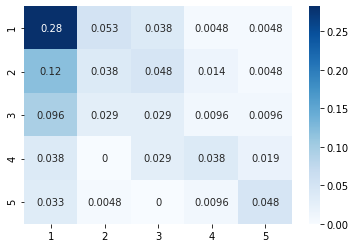

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

walc_predict = nn_walc.predict(X_test_w, True)
confusion_w = confusion_matrix(list(y_test_w.idxmax(axis=1)-1), list(walc_predict))
print("Mapa błędów dla weekendowego spożycia")
tmp = sns.heatmap(confusion_w/np.sum(confusion_w), cmap="Blues", annot=True, xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])


Mapa błędów dla dziennego spożycia


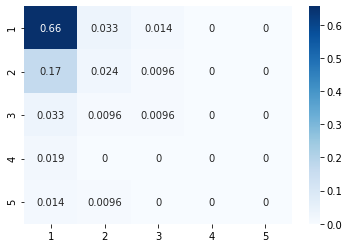

In [13]:
dalc_predict = nn_dalc.predict(X_test_d, True)
confusion_d = confusion_matrix(list(y_test_d.idxmax(axis=1)-1), list(dalc_predict))
print("Mapa błędów dla dziennego spożycia")
tmp = sns.heatmap(confusion_d/np.sum(confusion_d), cmap="Blues", annot=True, xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])

Pokazane powyżej mapy błędów tylko potwierdzają nasze spostrzeżenia, zwłaszcza w pzypadku badaniu spozycia dziennego, gdzie widać, że algorytm podaje na ogół wartość 1 dla danych wejściowych.   
W wypadku danych dla weekendowego spozycia sytuacja wydaje się być nieco lepsza, ponieważ model operuje także na pozostałych wartościach z zakresu 1-5. W prawdzie szansa na uzyskanie wtedy poprawnej wartości wcale nie jest duża, ale przynajmniej nie jest zerowa jak to jest w przypadku tygodniowego spożycia.

## Testy dla SIGMOID
Dla porównania przeprowadziliśmy też testy z użyciem neuronów sigmoidalnych zamiast ReLU


In [14]:
nn_walc = NeuralNetwork(d.get_num_of_columns(),[20],5, "sigmoid")
nn_dalc = NeuralNetwork(d.get_num_of_columns(),[20],5, "sigmoid")

In [15]:
epochs_number = 1000
print("Walc")
nn_walc.train(train_data=X_train_w,targets=y_train_w,epochs=epochs_number,batch_size=10,learning_rate=0.001,number_of_prints=5)
print("Dalc")
nn_dalc.train(train_data=X_train_d,targets=y_train_d,epochs=epochs_number,batch_size=10,learning_rate=0.001,number_of_prints=5)

Walc
epochs: 200 ==== error: 0.27422469057764415
epochs: 400 ==== error: 0.25767900243923453
epochs: 600 ==== error: 0.2498336420037708
epochs: 800 ==== error: 0.2444030146263341
epochs: 1000 ==== error: 0.24046423186179422
Dalc
epochs: 200 ==== error: 0.17608384049179152
epochs: 400 ==== error: 0.16781073773835709
epochs: 600 ==== error: 0.16315390697052848
epochs: 800 ==== error: 0.16003815064476914
epochs: 1000 ==== error: 0.15779620571012598


In [16]:
print("Dokładność przeiwdywań dla weekendowego spożycia:",round(nn_walc.test(np.asarray(X_test_w),np.asarray(y_test_w))*100,4),"%")
print("Dokładność przeiwdywań dla dziennego spożycia:",round(nn_dalc.test(np.asarray(X_test_d),np.asarray(y_test_d))*100,4),"%")

Dokładność przeiwdywań dla weekendowego spożycia: 44.4976 %
Dokładność przeiwdywań dla dziennego spożycia: 68.4211 %


Mapa błędów dla weekendowego spożycia


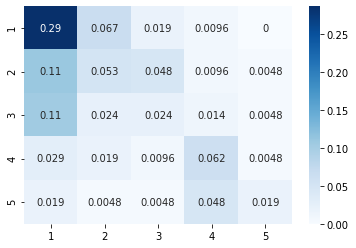

In [17]:
walc_predict = nn_walc.predict(X_test_w, True)
confusion_w = confusion_matrix(list(y_test_w.idxmax(axis=1)-1), list(walc_predict))
print("Mapa błędów dla weekendowego spożycia")
tmp = sns.heatmap(confusion_w/np.sum(confusion_w), cmap="Blues", annot=True, xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])

Mapa błędów dla dziennego spożycia


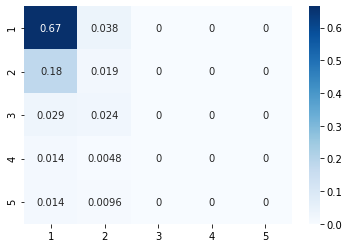

In [18]:
dalc_predict = nn_dalc.predict(X_test_d, True)
confusion_d = confusion_matrix(list(y_test_d.idxmax(axis=1)-1), list(dalc_predict))
print("Mapa błędów dla dziennego spożycia")
tmp = sns.heatmap(confusion_d/np.sum(confusion_d), cmap="Blues", annot=True, xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])

Z powyżej przedstawionych danych wynika, że zmiana funkcji aktywacji nie wpłynęła w znaczący sposób na dokładność wyników otrzymanych przez sieć, z tego powodu w ostatecznym rozrachunku lepszym rozwiązaniem może okazać się wykorzystywanie ReLU jako funkcji aktywacji, z powodu jej mniejszej złożoności obliczeniowej.


## Testy na większej ilości warstw

In [19]:
nn_walc = NeuralNetwork(d.get_num_of_columns(),[20,10],5, "relu")
nn_dalc = NeuralNetwork(d.get_num_of_columns(),[20,10],5, "relu")

In [20]:
print("Walc")
nn_walc.train(train_data=X_train_w,targets=y_train_w,epochs=epochs_number,batch_size=10,learning_rate=0.001,number_of_prints=5)
print("Dalc")
nn_dalc.train(train_data=X_train_d,targets=y_train_d,epochs=epochs_number,batch_size=10,learning_rate=0.001,number_of_prints=5)

Walc
epochs: 200 ==== error: 0.26564139332779746
epochs: 400 ==== error: 0.25151076849893417
epochs: 600 ==== error: 0.24361506605937386
epochs: 800 ==== error: 0.23552129070962388
epochs: 1000 ==== error: 0.23074574778306686
Dalc
epochs: 200 ==== error: 0.1730772292900048
epochs: 400 ==== error: 0.16803768231392646
epochs: 600 ==== error: 0.16437578034992203
epochs: 800 ==== error: 0.16028656687801057
epochs: 1000 ==== error: 0.1583963761645698


In [21]:
print("Dokładność przeiwdywań dla weekendowego spożycia:",round(nn_walc.test(np.asarray(X_test_w),np.asarray(y_test_w))*100,4),"%")
print("Dokładność przeiwdywań dla dziennego spożycia:",round(nn_dalc.test(np.asarray(X_test_d),np.asarray(y_test_d))*100,4),"%")

Dokładność przeiwdywań dla weekendowego spożycia: 38.756 %
Dokładność przeiwdywań dla dziennego spożycia: 69.378 %


Mapa błędów dla weekendowego spożycia


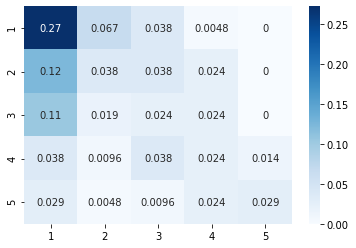

In [22]:
walc_predict = nn_walc.predict(X_test_w, True)
confusion_w = confusion_matrix(list(y_test_w.idxmax(axis=1)-1), list(walc_predict))
print("Mapa błędów dla weekendowego spożycia")
tmp = sns.heatmap(confusion_w/np.sum(confusion_w), cmap="Blues", annot=True, xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])

Mapa błędów dla dziennego spożycia


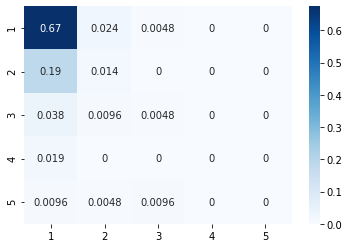

In [23]:
dalc_predict = nn_dalc.predict(X_test_d, True)
confusion_d = confusion_matrix(list(y_test_d.idxmax(axis=1)-1), list(dalc_predict))
print("Mapa błędów dla dziennego spożycia")
tmp = sns.heatmap(confusion_d/np.sum(confusion_d), cmap="Blues", annot=True, xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])

In [24]:
nn_walc = NeuralNetwork(d.get_num_of_columns(),[40,20,10],5, "relu")
nn_dalc = NeuralNetwork(d.get_num_of_columns(),[40,20,10],5, "relu")

In [25]:
print("Walc")
nn_walc.train(train_data=X_train_w,targets=y_train_w,epochs=epochs_number,batch_size=10,learning_rate=0.001,number_of_prints=5)
print("Dalc")
nn_dalc.train(train_data=X_train_d,targets=y_train_d,epochs=epochs_number,batch_size=10,learning_rate=0.001,number_of_prints=5)

Walc
epochs: 200 ==== error: 0.29380673913024397
epochs: 400 ==== error: 0.2937106532013239
epochs: 600 ==== error: 0.2627916391933645
epochs: 800 ==== error: 0.25182016288888576
epochs: 1000 ==== error: 0.2509740731802664
Dalc
epochs: 200 ==== error: 0.18872706527028354
epochs: 400 ==== error: 0.1884259129077386
epochs: 600 ==== error: 0.1863831274445641
epochs: 800 ==== error: 0.16475277748009637
epochs: 1000 ==== error: 0.16169796184601745


In [26]:
print("Dokładność przeiwdywań dla weekendowego spożycia:",round(nn_walc.test(np.asarray(X_test_w),np.asarray(y_test_w))*100,4),"%")
print("Dokładność przeiwdywań dla dziennego spożycia:",round(nn_dalc.test(np.asarray(X_test_d),np.asarray(y_test_d))*100,4),"%")

Dokładność przeiwdywań dla weekendowego spożycia: 45.933 %
Dokładność przeiwdywań dla dziennego spożycia: 69.378 %


Mapa błędów dla weekendowego spożycia


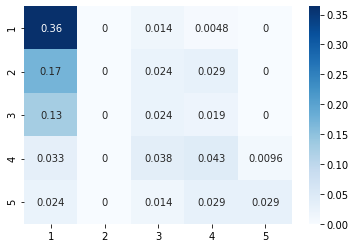

In [27]:
walc_predict = nn_walc.predict(X_test_w, True)
confusion_w = confusion_matrix(list(y_test_w.idxmax(axis=1)-1), list(walc_predict))
print("Mapa błędów dla weekendowego spożycia")
tmp = sns.heatmap(confusion_w/np.sum(confusion_w), cmap="Blues", annot=True, xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])

Mapa błędów dla dziennego spożycia


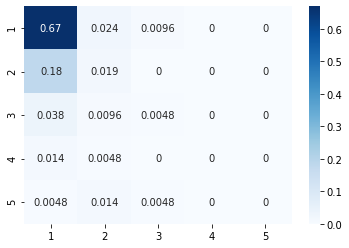

In [28]:
dalc_predict = nn_dalc.predict(X_test_d, True)
confusion_d = confusion_matrix(list(y_test_d.idxmax(axis=1)-1), list(dalc_predict))
print("Mapa błędów dla dziennego spożycia")
tmp = sns.heatmap(confusion_d/np.sum(confusion_d), cmap="Blues", annot=True, xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])

In [29]:
clf_w = MLPClassifier(random_state=1, max_iter=epochs_number, hidden_layer_sizes=(50)).fit(X_train_w, y_train_w)
print("Dokładność przwidywań dla weekendowego spożycia:", round(100*clf_w.score(X_test_w, y_test_w),3),"%")
clf_d = MLPClassifier(random_state=1, max_iter=epochs_number, hidden_layer_sizes=(50)).fit(X_train_d, y_train_d)
print("Dokładność przwidywań dla dziennego spożycia:", round(100*clf_d.score(X_test_d, y_test_d),3),"%")

Dokładność przwidywań dla weekendowego spożycia: 45.455 %
Dokładność przwidywań dla dziennego spożycia: 67.943 %


In [30]:
nn_walc = NeuralNetwork(d.get_num_of_columns(),[50],5, "relu")
nn_dalc = NeuralNetwork(d.get_num_of_columns(),[50],5, "relu")

In [31]:
print("Walc")
nn_walc.train(train_data=X_train_w,targets=y_train_w,epochs=epochs_number,batch_size=10,learning_rate=0.001,number_of_prints=5)
print("Dalc")
nn_dalc.train(train_data=X_train_d,targets=y_train_d,epochs=epochs_number,batch_size=10,learning_rate=0.001,number_of_prints=5)

Walc
epochs: 200 ==== error: 0.24736785303318526
epochs: 400 ==== error: 0.23398164096847393
epochs: 600 ==== error: 0.2292861811389018
epochs: 800 ==== error: 0.227097205236724
epochs: 1000 ==== error: 0.22581531560463539
Dalc
epochs: 200 ==== error: 0.15689249293017474
epochs: 400 ==== error: 0.15271551414426365
epochs: 600 ==== error: 0.14987857420668377
epochs: 800 ==== error: 0.14777386240378354
epochs: 1000 ==== error: 0.14597236337037586


In [32]:
print("Dokładność przeiwdywań dla weekendowego spożycia:",round(nn_walc.test(np.asarray(X_test_w),np.asarray(y_test_w))*100,4),"%")
print("Dokładność przeiwdywań dla dziennego spożycia:",round(nn_dalc.test(np.asarray(X_test_d),np.asarray(y_test_d))*100,4),"%")

Dokładność przeiwdywań dla weekendowego spożycia: 40.6699 %
Dokładność przeiwdywań dla dziennego spożycia: 68.8995 %


Z powyższych testów wynika, że rozmiar sieci nie ma zbyt wielkiego przełożenia na dokładność uzyskiwanych za jej pomocą wyników, jedyną wartą uwagi różnicą jest różnica wydajnościowa pomiędzy poszczególnymi wymiarami sieci.

## Wnioski
Wygląda na to, że w badanym zbiorze danych nie da się łatwo przewidzieć spożycia alkoholu na podstawie pozostałych danych, w prawdzie w niektórych przypadkach można uzyskać rezultaty wykraczające poza rachunek prawdopodobieństwa, ale jest to najczęściej spowodowane "lenistwem" sieci, która po prostu prawie zawsze wybiera wartość najczęściej występującą w zbiorze, co pozwala dość łatwo uzyskać dobry rezultat w dużej części przypadków.  
Zaobserwowaliśmy także, że w wypadku z bardziej zróżnicowanym zbiorem danych (spożycie weekendowe) to zjawisko było nieco mniej odczuwalne. Może to oznaczać, że w niektórych przypadkach warto zastanowić się nad ograniczeniem liczebności grupy dominującej w naszym zbiorze, co mogłoby ograniczyć skutki tego zjawiska.

W badanym przypadku zastosowanie zmiana układu oraz rozmiaru sieci w minimalnym stopniu wpłynęło na dokładność przewidywań sieci.
 
Zauważyliśmy też problem z eksplodującym gradientem. Należy więc ostrożnie dobierać wielkość learning_rate i batch_size. Żeby ograniczyć wpływ zastosowaliśmy nasycenie funkcji ReLU do maksymalnej wartości 50. Gdybyśmy zastosowali regularyzacje L2 możliwe że dałoby się całkowicie ominąć ten problem.

### Czego się nauczyliśmy

Dzięki realizacji tego projektu poprawiliśmy naszą znajomość:  
 - zasad działania oraz budowy sieci neuronowych  
 - narzędzi do analizy oraz obróbki danych  
 - składni oraz specyfiki języka Python  